# Embedding Model

In [6]:
#Dependencies
import pandas as pd
import numpy as np
import itertools

import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.express as px

import time
import tqdm


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'floral-dataset/')
STATE_SIZE = 10

In [8]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]
florals_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'florals.dat'),encoding='latin-1').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'floralID', 'Rating', 'Timestamp'], dtype = np.uint32)
florals_df = pd.DataFrame(florals_list, columns = ['floralID', 'Title', 'Genres'])
florals_df['floralID'] = florals_df['floralID'].apply(pd.to_numeric)
users_df = pd.DataFrame(users_list, columns=['UserID','Gender','Age','Occupation','Zip-code'])

In [9]:

florals_id_to_florals = {floral[0]: floral[1:] for floral in florals_list}

In [10]:
len(florals_list)

4040

In [11]:
florals_df.head(5)

,floralID,Title,Genres
0,1,Lily-Flowered Tulips,Tulips|Magenta
1,2,Zygopetalum OrchidsPhalaenopsis Orchids,Orchids|Red
2,3,Rosellaï¿½s Dream,Lilies|Purple
3,4,Shock-O-Lat,Sunflowers|Red
4,5,Dianthus superbus,Carnations|Purple


In [12]:
ratings_df.head(5)

,UserID,floralID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [13]:
genres = ['Magenta',
        'Ivory',
        'Lilies',
        "Red",
        'Roses',
        'Orchids',
        'Blue',
        'Sunflowers',
        'Purple',
        'Green',
        'White',
        'Orange',
        'Carnations',
        'Yellow',
        'Poppies',
        'Iris',
        'Bougainvilleas',
        'Tulips']

In [14]:

florals_genres_df = florals_df[['floralID', 'Genres']]

In [15]:
florals_genres_df.head(5)

,floralID,Genres
0,1,Tulips|Magenta
1,2,Orchids|Red
2,3,Lilies|Purple
3,4,Sunflowers|Red
4,5,Carnations|Purple


In [16]:

def _split_and_index(string):
    string = string.split('|')
    for i, s in enumerate(string):
        string[i] = genres.index(s)
    return string

florals_genres_df['Genres'] = florals_genres_df['Genres'].map(lambda x : _split_and_index(x))

C:\Users\User\AppData\Local\Temp/ipykernel_9520/2961287488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florals_genres_df['Genres'] = florals_genres_df['Genres'].map(lambda x : _split_and_index(x))


In [17]:
florals_genres_df.head(5)

,floralID,Genres
0,1,"[17, 0]"
1,2,"[5, 3]"
2,3,"[2, 8]"
3,4,"[7, 3]"
4,5,"[12, 8]"


In [18]:

florals_genres_df.isnull().sum()

floralID    0
Genres      0
dtype: int64

In [19]:

len(florals_genres_df['floralID'])

4040

In [20]:
florals_genres_df['floralID'].nunique()

4040

In [21]:

user_floral_rating_df = ratings_df[['UserID','floralID','Rating']]

In [22]:
user_floral_rating_df.head(5)

,UserID,floralID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [23]:

user_floral_rating_df.isnull().sum()

UserID      0
floralID    0
Rating      0
dtype: int64

In [24]:
user_floral_rating_df['UserID'].nunique()

6040

In [25]:
user_floral_rating_df['floralID'].nunique()

3706

##  Case1. 

In [26]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

### floral Genre Embedding 

In [27]:
class floralGenreEmbedding(tf.keras.Model):
    def __init__(self, len_florals, len_genres, embedding_size):
        super(floralGenreEmbedding, self).__init__()
        self.m_g_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.m_embedding = Embedding(name='floral_embedding', input_dim=len_florals, output_dim=embedding_size)
        self.g_embedding = Embedding(name='genre_embedding', input_dim=len_genres, output_dim=embedding_size)
        # dot product
        self.m_g_merge = Dot(name='floral_genre_dot', normalize=True, axes=1)
        # output
        self.m_g_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_g_input(x)
        memb = self.m_embedding(x[0])
        gemb = self.g_embedding(x[1])
        m_g = self.m_g_merge([memb, gemb])
#         m_g = self.reshape(m_g)
        return self.m_g_fc(m_g)

In [28]:
class UserfloralEmbedding(tf.keras.Model):
    def __init__(self, len_users, embedding_size):
        super(UserfloralEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='floral_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        m_u = self.m_u_merge([x[1], uemb])
        return self.m_u_fc(m_u)

In [29]:

florals_genres_df.head()

,floralID,Genres
0,1,"[17, 0]"
1,2,"[5, 3]"
2,3,"[2, 8]"
3,4,"[7, 3]"
4,5,"[12, 8]"


In [30]:
florals_genres_dict = {m : g for m, g in zip(florals_genres_df["floralID"],florals_genres_df["Genres"])}
florals_genres_dict[1]

[17, 0]

In [31]:
positive_m_g_pairs = []
negative_m_g_pairs = []
for floral in florals_genres_df["floralID"]:
    for i in range(len(genres)):
        if i in florals_genres_dict[floral]:
            positive_m_g_pairs.append((floral, i, 1))
        else:
            negative_m_g_pairs.append((floral, i, 0))

In [32]:
def generate_floral_genre_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):
    
    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)
    
    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data
        
        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [33]:

user_floral_rating_df = user_floral_rating_df.apply(np.int32)
user_floral_rating_df.head()

,UserID,floralID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [34]:
modified_user_floral_rating_df = user_floral_rating_df.apply(np.int32)
index_names = modified_user_floral_rating_df[modified_user_floral_rating_df['Rating']<4].index
modified_user_floral_rating_df = modified_user_floral_rating_df.drop(index_names)
modified_user_floral_rating_df = modified_user_floral_rating_df.drop('Rating', axis=1)
u_m_pairs = modified_user_floral_rating_df.to_numpy()
u_m_pairs[:5]

array([[   1, 1193],
       [   1, 3408],
       [   1, 2355],
       [   1, 1287],
       [   1, 2804]])

In [35]:
positive_user_floral_dict = {u : [] for u in range(1, max(modified_user_floral_rating_df['UserID'])+1)}
for data in modified_user_floral_rating_df.iterrows():
    positive_user_floral_dict[data[1][0]].append(data[1][1])
positive_user_floral_dict[1]

[1193,
 3408,
 2355,
 1287,
 2804,
 594,
 919,
 595,
 938,
 2398,
 2918,
 1035,
 2791,
 2018,
 3105,
 2797,
 1270,
 527,
 48,
 1097,
 1721,
 1545,
 2294,
 3186,
 1566,
 588,
 1907,
 783,
 1836,
 1022,
 2762,
 150,
 1,
 1961,
 1962,
 2692,
 260,
 1028,
 1029,
 1207,
 2028,
 531,
 3114,
 608,
 1246]

In [36]:
def generate_user_floral_batch(positive_pairs, batch_size, negative_ratio=0.5):
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(modified_user_floral_rating_df['UserID'])+1
    max_floral_id = max(modified_user_floral_rating_df['floralID'])+1
    
    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)
        
        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_floral_id)
            if m not in positive_user_floral_dict[u]:
                i += 1
                batch[i] = (u, m, 0)
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [37]:
LEN_floralS = max(florals_genres_df["floralID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_floral_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

MAX_EPOCH = 100
floral_BATCH_SIZE = 128
floral_STEP_PER_EPOCH = len(positive_m_g_pairs)//floral_BATCH_SIZE

In [38]:
m_g_model = floralGenreEmbedding(LEN_floralS, LEN_GENRES, EMBEDDING_SIZE)

In [39]:
m_g_model([np.zeros((1)),np.zeros((1))])
m_g_model.summary()

Model: "floral_genre_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
floral_embedding (Embedding) multiple                  404100    
_________________________________________________________________
genre_embedding (Embedding)  multiple                  1900      
_________________________________________________________________
floral_genre_dot (Dot)       multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2         
Total params: 406,002
Trainable params: 406,002
Non-trainable params: 0
_________________________________________________________________


In [40]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [41]:
m_g_train_loss = tf.keras.metrics.Mean(name='train_loss')
m_g_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def m_g_train_step(m_g_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = m_g_model(m_g_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, m_g_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m_g_model.trainable_variables))

    m_g_train_loss(loss)
    m_g_train_accuracy(labels, predictions)

In [42]:
# for log
m_g_losses = []

for epoch in range(MAX_EPOCH):
    
    m_g_generator = generate_floral_genre_batch(positive_m_g_pairs, negative_m_g_pairs, floral_BATCH_SIZE, negative_ratio=0.5)
    
    for step in range(floral_STEP_PER_EPOCH):
        # embedding layer update
        m_batch, g_batch, m_g_label_batch = next(m_g_generator)
        m_g_train_step([m_batch, g_batch], m_g_label_batch)
        
        print(f'{epoch} epoch, {step} steps, Loss: {m_g_train_loss.result():0.4f}, Accuracy: {m_g_train_accuracy.result() * 100:0.1f}', end='\r')

    m_g_losses.append(m_g_train_loss.result())

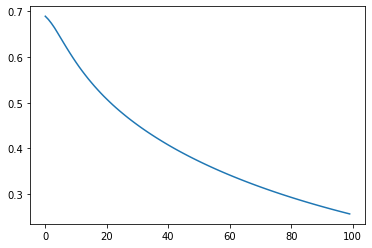

In [43]:
plt.plot(m_g_losses)

In [44]:
m_g_model.save_weights('./save_weights/m_g_model_weights.h5')

### User floral Embedding

In [45]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [46]:
u_m_model = UserfloralEmbedding(LEN_USERS, EMBEDDING_SIZE)

In [47]:
u_m_model([np.zeros((1)),np.zeros((1,100))])
u_m_model.summary()

Model: "userfloral_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
user_embedding (Embedding)   multiple                  604100    
_________________________________________________________________
floral_user_dot (Dot)        multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  2         
Total params: 604,102
Trainable params: 604,102
Non-trainable params: 0
_________________________________________________________________


In [48]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [49]:
u_m_train_loss = tf.keras.metrics.Mean(name='train_loss')
u_m_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def u_m_train_step(u_m_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = u_m_model(u_m_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, u_m_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_m_model.trainable_variables))

    u_m_train_loss(loss)
    u_m_train_accuracy(labels, predictions)

In [50]:
# for log
u_m_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    u_m_generator = generate_user_floral_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_floral_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(u_m_generator)
        m_batch = m_g_model.get_layer('floral_embedding')(m_batch)
        u_m_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {u_m_train_loss.result():0.4f}, Accuracy: {u_m_train_accuracy.result() * 100:0.1f}', end='\r')

    u_m_losses.append(u_m_train_loss.result())

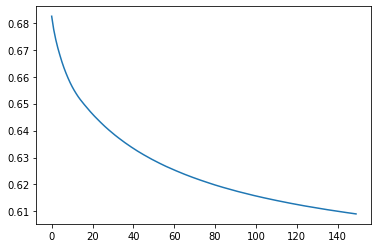

In [51]:
plt.plot(u_m_losses)

In [52]:
u_m_model.save_weights('./save_weights/u_m_model_weights.h5')

In [53]:

# model.load_weights('./save_weights/embedding_24epoch.h5')

In [54]:
# embedded floral dataframe 
embedded_floral = florals_genres_df['floralID'].apply(m_g_model.get_layer('floral_embedding'))
columns = [x for x in range(100)]
embedded_floral_df = pd.DataFrame(columns = columns)
for data in embedded_floral:
    embedded_floral_df = embedded_floral_df.append(pd.Series(data), ignore_index=True)
embedded_floral_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.027886,-0.161009,0.035800,0.134344,0.060729,-0.118216,-0.041821,0.058410,-0.003727,0.087769,...,-0.056144,-0.032821,0.016003,0.087987,0.080089,-0.037038,-0.005594,-0.018600,0.154185,-0.046170
1,0.081244,-0.114286,0.108257,0.090655,0.040107,0.097371,0.038578,-0.132650,0.060892,0.077182,...,0.003041,0.132364,0.013984,0.005026,0.055000,0.004414,0.040064,-0.040401,-0.075810,-0.026577
2,0.039337,0.161965,-0.177632,-0.106887,0.033467,0.041359,0.003173,-0.104465,0.030119,0.038628,...,-0.157699,0.138724,0.014487,0.016063,0.056285,-0.135635,0.126958,0.129218,-0.140267,-0.004420
3,0.038826,0.012531,-0.046827,0.144461,-0.027239,0.107753,0.021031,-0.090761,-0.038380,-0.006582,...,0.079880,-0.011466,-0.014319,-0.016141,0.068715,-0.110915,-0.001799,0.074073,-0.082986,-0.003794
4,0.081381,0.063745,-0.038531,-0.029175,0.015713,-0.082273,-0.010929,-0.127480,-0.024769,0.023462,...,-0.067293,0.068259,0.039108,0.030839,0.104873,-0.008311,0.163456,0.035307,-0.019900,-0.029995


In [55]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

floral_scaled = StandardScaler().fit_transform(embedded_floral_df)
pca = PCA(n_components=2)
pca.fit(floral_scaled)
floral_pca = pca.transform(floral_scaled)
pca_columns=[f'{n}' for n in range(2)]
floral_df_pca = pd.DataFrame(floral_pca,columns=pca_columns)
floral_df_pca = pd.concat([floral_df_pca, florals_df["Title"]], axis=1)
floral_df_pca = pd.concat([floral_df_pca, florals_df["Genres"]], axis=1)
floral_df_pca.head()

,0,1,Title,Genres
0,-1.534008,-2.926361,Lily-Flowered Tulips,Tulips|Magenta
1,-0.937562,-0.924135,Zygopetalum OrchidsPhalaenopsis Orchids,Orchids|Red
2,5.321756,0.751514,Rosellaï¿½s Dream,Lilies|Purple
3,-1.325797,-1.222160,Shock-O-Lat,Sunflowers|Red
4,5.574629,2.183981,Dianthus superbus,Carnations|Purple


In [56]:

fig = px.scatter(floral_df_pca, x='0', y='1', color='Genres')
fig.show()

In [57]:

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_floral_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, florals_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, florals_df["Genres"]], axis=1)
tsne_df.head()

,x,y,Title,Genres
0,32.506145,12.980248,Lily-Flowered Tulips,Tulips|Magenta
1,-2.140640,72.877205,Zygopetalum OrchidsPhalaenopsis Orchids,Orchids|Red
2,9.658393,-17.701454,Rosellaï¿½s Dream,Lilies|Purple
3,-37.295513,-49.845707,Shock-O-Lat,Sunflowers|Red
4,2.175955,17.425186,Dianthus superbus,Carnations|Purple


In [58]:

fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [59]:

embedded_user = users_df['UserID'].apply(np.int32).apply(u_m_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.500198,0.197106,0.334197,-0.364029,-0.419903,-0.612732,-0.826334,0.031489,-0.023057,0.104622,...,-0.922842,-0.492760,0.421869,-0.116162,0.492271,0.207068,-0.258638,-0.486035,0.152914,0.298796
1,-0.156452,0.027243,0.060220,-0.005097,-0.296697,-0.170975,-0.278053,0.069311,-0.036609,0.117855,...,-0.145439,-0.122733,-0.065047,-0.174567,0.133900,0.299043,-0.178636,0.031565,0.016319,-0.033470
2,-0.213148,0.236287,0.112996,-0.130039,-0.423226,-0.413108,-0.676118,-0.006194,-0.254136,0.114769,...,-0.821401,-0.661766,0.020082,0.039975,0.379072,0.076946,-0.169546,-0.426545,0.091397,0.288394
3,-1.068862,0.329213,0.313068,-0.778973,-1.263406,-0.970394,-1.980653,0.310882,-0.757976,0.468882,...,-1.909334,-1.379129,0.794074,-0.472731,1.061217,0.432272,-0.433257,-0.942965,0.628185,0.578304
4,0.029810,0.032304,0.276904,0.074910,-0.206320,-0.108186,-0.243072,-0.039735,-0.250943,0.029680,...,0.073000,-0.224379,0.138528,-0.114388,0.036919,0.210094,0.194434,-0.352624,0.115301,0.229418


In [60]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [61]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

user_scaled = StandardScaler().fit_transform(embedded_user_df)
pca = PCA(n_components=2)
pca.fit(user_scaled)
user_pca = pca.transform(user_scaled)
pca_columns=[f'{n}' for n in range(2)]
user_df_pca = pd.DataFrame(user_pca,columns=pca_columns)
user_df_pca = pd.concat([user_df_pca, users_df["Gender"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Age"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Zip-code"]], axis=1)
user_df_pca.head()

,0,1,Gender,Age,Zip-code
0,-3.277558,1.092688,F,1,48067
1,1.984866,2.522729,M,56,70072
2,-2.825558,-1.063663,M,25,55117
3,-13.550787,1.442759,M,45,02460
4,2.678466,2.465838,M,25,55455


In [62]:

fig = px.scatter(user_df_pca, x='0', y='1', hover_data=user_df_pca)
fig.show()

In [63]:

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

,x,y,Gender,Age,Zip-code
0,26.827316,-27.518908,F,1,48067
1,-25.321304,-32.099651,M,56,70072
2,26.015400,-40.474957,M,25,55117
3,19.811682,38.750271,M,45,02460
4,-29.670397,-40.888905,M,25,55455


In [64]:

fig = px.scatter(tsne_df, x='x', y='y', hover_data=tsne_df)
fig.show()

##  Case2.

In [65]:
LEN_floralS = max(florals_genres_df["floralID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_floral_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

In [66]:
class TestUserfloralEmbedding(tf.keras.Model):
    def __init__(self, len_users, len_florals, embedding_size):
        super(TestUserfloralEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        self.m_embedding = Embedding(name='floral_embedding', input_dim=len_florals, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='floral_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        memb = self.m_embedding(x[1])
        m_u = self.m_u_merge([memb, uemb])
        return self.m_u_fc(m_u)

In [67]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [68]:
test_model = TestUserfloralEmbedding(LEN_USERS, LEN_floralS, EMBEDDING_SIZE)

test_model([np.zeros((1)),np.zeros((1))])
test_model.summary()

Model: "test_userfloral_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
user_embedding (Embedding)   multiple                  604100    
_________________________________________________________________
floral_embedding (Embedding) multiple                  404100    
_________________________________________________________________
floral_user_dot (Dot)        multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2         
Total params: 1,008,202
Trainable params: 1,008,202
Non-trainable params: 0
_________________________________________________________________


In [69]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [70]:
test_train_loss = tf.keras.metrics.Mean(name='train_loss')
test_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def test_train_step(test_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = test_model(test_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, test_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, test_model.trainable_variables))

    test_train_loss(loss)
    test_train_accuracy(labels, predictions)

In [71]:
# for log
test_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    test_generator = generate_user_floral_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_floral_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(test_generator)
        test_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {test_train_loss.result():0.4f}, Accuracy: {test_train_accuracy.result() * 100:0.1f}', end='\r')

    test_losses.append(test_train_loss.result())

In [72]:

embedded_floral = florals_genres_df['floralID'].apply(test_model.get_layer('floral_embedding'))
columns = [x for x in range(100)]
embedded_floral_df = pd.DataFrame(columns = columns)
for data in embedded_floral:
    embedded_floral_df = embedded_floral_df.append(pd.Series(data), ignore_index=True)
embedded_floral_df.head()


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

floral_scaled = StandardScaler().fit_transform(embedded_floral_df)
pca = PCA(n_components=2)
pca.fit(floral_scaled)
floral_pca = pca.transform(floral_scaled)
pca_columns=[f'{n}' for n in range(2)]
floral_df_pca = pd.DataFrame(floral_pca,columns=pca_columns)
floral_df_pca = pd.concat([floral_df_pca, florals_df["Title"]], axis=1)
floral_df_pca = pd.concat([floral_df_pca, florals_df["Genres"]], axis=1)
floral_df_pca.head()


fig = px.scatter(floral_df_pca, x='0', y='1', color='Genres')
fig.show()

In [73]:

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_floral_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, florals_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, florals_df["Genres"]], axis=1)
tsne_df.head()

fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [74]:

embedded_user = users_df['UserID'].apply(np.int32).apply(test_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.240861,-0.442019,-0.460337,-0.274728,0.803104,-0.961003,0.375708,0.117244,0.477337,0.506413,...,0.018694,2.154561,-0.460808,-0.802442,-0.723306,-0.793255,0.675974,0.152525,-0.334523,0.875636
1,2.002791,-0.420871,0.049213,0.641719,-0.567661,-0.028468,0.362889,-0.205042,-0.816099,-0.269882,...,-0.234135,1.538886,-0.748053,0.160244,-1.500423,0.519898,0.649201,1.517816,0.295946,-0.394785
2,-0.468017,-1.477476,-0.712298,0.625644,0.327545,0.840657,0.196770,-1.439891,-0.944314,-0.563770,...,-1.019420,0.093706,0.114548,-1.126822,-0.906886,-0.038780,0.858506,-0.362174,0.841759,1.217249
3,-0.364900,0.052191,0.087025,0.462198,0.407332,0.237487,-0.178487,-0.156540,-0.382899,0.484624,...,0.535295,0.487176,-0.906717,0.453612,-0.208345,0.547958,0.641263,0.457303,1.004728,0.675359
4,0.199800,-0.224415,0.375906,0.603817,0.027243,0.227901,-0.025366,-0.400959,1.113267,-0.229799,...,0.536425,0.841544,-0.606132,0.010640,-0.256852,0.240380,0.925739,-0.283857,0.086028,-0.350192


In [75]:

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

,x,y,Gender,Age,Zip-code
0,-2.402113,-10.842812,F,1,48067
1,-6.043363,3.770722,M,56,70072
2,-3.464921,18.022951,M,25,55117
3,-23.470516,-34.545918,M,45,02460
4,15.043240,-13.170489,M,25,55455


In [76]:

fig = px.scatter(tsne_df, x='x', y='y', color='Age', hover_data=tsne_df)
fig.show()

In [77]:
test_model.save_weights('./save_weights/user_floral_at_once.h5')